#### import neccessary libraries


In [29]:
import os 
# changing directory path 
os.chdir('F:\\New Start\\My projects\\Ecommerce Sentiment Analysis')
import numpy  as np
import pandas  as pd
import matplotlib.pyplot as plt 
from scripts.data_preprocessing import CleanReview
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading Dataset

In [2]:
data=pd.read_csv('F:\\New Start\\My projects\\Ecommerce Sentiment Analysis\\data\\cleaned\\cleaned_data.csv',encoding='utf-8')

In [3]:
# checking null values 
data.isnull().sum()

Review       0
Sentiment    0
dtype: int64

In [4]:
data.shape

(95272, 2)

#### Data Preprocessing on Review

In [5]:
### creating object of CLeanReview class
cr=CleanReview()

In [6]:
print("Processing has started")
data['Review']=data['Review'].apply(cr.clean_html)
print("clean html has completed")
data['Review']=data['Review'].apply(cr.convert_lower)
print("text has been converted into lower case ")
data['Review']=data['Review'].apply(cr.remove_special)
print("Special charactors has been removed")
data['Review']=data['Review'].apply(cr.remove_stopwords)
print("Stopwords has been removed")
data['Review']=data['Review'].apply(cr.stem_words)
print("Stemmetization has been done.")

Processing has started
clean html has completed
text has been converted into lower case 
Special charactors has been removed
Stopwords has been removed
Stemmetization has been done.


In [7]:
data['Review']=data['Review'].apply(cr.join_back)
print("Text has been joined back")
data['Review']=data['Review'].apply(cr.remove_emojis)
print("Emojis has been removed.")
print("Preprocessing has been ended.")

Text has been joined back
Emojis has been removed.
Preprocessing has been ended.


In [8]:
## convert output column into numbers
def convert(text):
    if text=='positive':
       return 1
    elif text=='negative':
        return -1
    else:
        return 0
    
data['Sentiment']=data['Sentiment'].apply(convert)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95272 entries, 0 to 95271
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     95272 non-null  object
 1   Sentiment  95272 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


#### Check Class Imbalanced

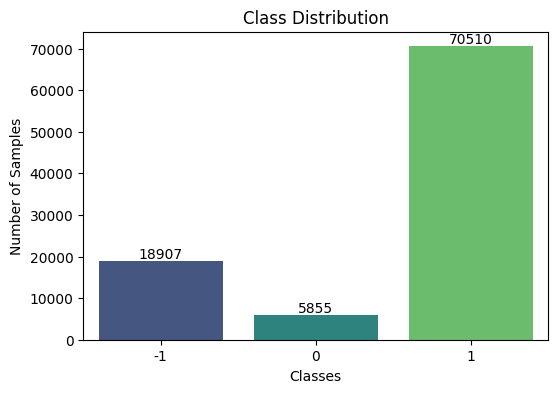

In [34]:
# Example: replace with your real counts
class_counts = data["Sentiment"].value_counts()

plt.figure(figsize=(6,4))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# --- Works for ALL bars ---
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.show()

#### Handling Imbalanced Class

- reduce the Majority_class

In [54]:
positive_reviews=data[data['Sentiment']==1].head(40000)

In [55]:
positive_reviews

,Review,Sentiment
0,great cooler excel air flow price amaz unbelie...,1
1,best budget 2 fit cooler nice cool,1
2,qualiti good power air decent,1
3,cooler realli fantast provid good air flow hig...,1
4,good product,1
...,...,...
39995,nice televis slim realli android tv stand qual...,1
39996,face troubl 1 screen mirror work 2 system get ...,1
39997,one best tv got rs 19300thankyou flipkart,1
39998,play high definit video errorr video got end s...,1


In [56]:
other_sentiment=data[data['Sentiment']!=1]
other_sentiment

,Review,Sentiment
50000,bad product fan,-1
50001,ok ok product,0
50002,bad cooler,-1
50003,bad qualiti,-1
50004,small wire moter capac low fan speed good flow...,-1
...,...,...
74757,get 2 blur patch right hand side screen,-1
74758,hdmi cabl poor qualiti,-1
74759,pro slim border line style lightweight compact...,0
74760,littl bit angri lcd monitor hd led describ hea...,0


In [57]:
data = pd.concat([positive_reviews, other_sentiment], axis=0, ignore_index=True)

In [59]:
data['Sentiment'].value_counts()

Sentiment
 1    40000
-1    18907
 0     5855
Name: count, dtype: int64

- Let's convert them into numbers

- Count Vectorizer (Bag of Words) 

In [60]:
from sklearn.feature_extraction.text import CountVectorizer  

In [61]:
vec=CountVectorizer(max_features=20000)

In [62]:
X=vec.fit_transform(data['Review'])
y=data['Sentiment']

- save count vectorizer for test use

In [92]:
with open("embedding_model/count_vectorizer.pkl", "wb") as f:
    pickle.dump(vec, f)


- Apply SMOTE to handle the imbalanced class

In [63]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={-1: 35000, 0: 35000}, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

print("Before SMOTE:", y.value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())

Before SMOTE: Sentiment
 1    40000
-1    18907
 0     5855
Name: count, dtype: int64
After SMOTE: Sentiment
 1    40000
-1    35000
 0    35000
Name: count, dtype: int64


#### Train-test Split

In [68]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.3,random_state=51)

In [69]:
print("X train shape :",X_train.shape)
print("y train shape :",y_train.shape)
print("X test shape :",X_test.shape)
print("y train shape :",y_test.shape)

X train shape : (77000, 20000)
y train shape : (77000,)
X test shape : (33000, 20000)
y train shape : (33000,)


#### Creating Pipeline of Embedding + Model 

- Naive Bayes Classifier

In [72]:
### load the model 
model=MultinomialNB()


#### Model Training

In [73]:
model.fit(X_train,y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [74]:
y_pred=model.predict(X_test)

In [75]:
print("accurracy of Naive Bayes Classifier :", accuracy_score(y_test,y_pred))
print("Precision Score of Naive Bayes Classifier :",precision_score(y_test,y_pred,average='macro'))
print("Recall Score of Naive Bayes Classifier :",recall_score(y_test,y_pred,average='macro'))
print("F1 Score of Naive bayes Classifier :",f1_score(y_test,y_pred,average='macro'))

accurracy of Naive Bayes Classifier : 0.6786060606060607
Precision Score of Naive Bayes Classifier : 0.6831040584340183
Recall Score of Naive Bayes Classifier : 0.670555299835299
F1 Score of Naive bayes Classifier : 0.6683419058323969


- although accurracy score is not that much good . 
- but precision and recall not that much good. 
- because precision is how much correct predicted out of all prediction 
- recall how much correct predicted out of all actual result .

- Apply mlflow for monitoring 

In [76]:
import mlflow 
import warnings
warnings.filterwarnings('ignore')
from mlflow.models import infer_signature
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
signature=infer_signature(X_train,y_train)
# start the Mlflow experiments
with mlflow.start_run():
# log metrics 
    mlflow.log_metric("Accuracy ",accuracy_score(y_test,y_pred))
    mlflow.log_metric("Precision ",precision_score(y_test,y_pred,average='macro'))
    mlflow.log_metric("Recall",recall_score(y_test,y_pred,average='macro'))
    mlflow.log_metric("F1 Score",f1_score(y_test,y_pred,average='macro'))

    mlflow.sklearn.log_model(
    sk_model=model,
    artifact_path="Sentiment Analysis Model",
    registered_model_name="Naive bayes Classifier",
   )

2025/09/13 21:46:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/13 21:46:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Naive bayes Classifier' already exists. Creating a new version of this model...
2025/09/13 21:46:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Naive bayes Classifier, version 2


🏃 View run worried-kit-441 at: http://127.0.0.1:5000/#/experiments/0/runs/1c2db823bd9f48ecbc71f7dcf8a18bfd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Created version '2' of model 'Naive bayes Classifier'.


- XGBoost

In [77]:
import xgboost as xgb
from xgboost import XGBClassifier

In [78]:
xgb_clf = XGBClassifier(
    objective="multi:softmax",  # for multiclass classification
    num_class=3,                # number of classes (Positive, Negative, Neutral)
    eval_metric="mlogloss",     # loss function for multiclass
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    random_state=42
)

- softmax excepts --> 0,1,2 instead of -1,0,1

In [88]:
mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = np.array([mapping[val] for val in y_train])
y_test_mapped = np.array([mapping[val] for val in y_test])

In [83]:
xgb_clf.fit(X_train, y_train_mapped)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [84]:
y_pred_xgb = xgb_clf.predict(X_test)

In [89]:
print("accurracy of Naive Bayes Classifier :", accuracy_score(y_test_mapped,y_pred_xgb))
print("Precision Score of Naive Bayes Classifier :",precision_score(y_test_mapped,y_pred_xgb,average='macro'))
print("Recall Score of Naive Bayes Classifier :",recall_score(y_test_mapped,y_pred_xgb,average='macro'))
print("F1 Score of Naive bayes Classifier :",f1_score(y_test_mapped,y_pred_xgb,average='macro'))

accurracy of Naive Bayes Classifier : 0.7866969696969697
Precision Score of Naive Bayes Classifier : 0.7958411649548447
Recall Score of Naive Bayes Classifier : 0.7826294174711729
F1 Score of Naive bayes Classifier : 0.7810794572072628


- Apply mlflow for XGBoost

In [91]:
import mlflow 
import warnings
warnings.filterwarnings('ignore')
from mlflow.models import infer_signature
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
signature=infer_signature(X_train,y_train)
# start the Mlflow experiments
with mlflow.start_run():
# log metrics 
    mlflow.log_params({
        "objective": "multi:softmax",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "learning_rate": 0.1,
        "max_depth": 6,
        "n_estimators": 200,
        "random_state": 42
    })
    mlflow.log_metric("Accuracy ",accuracy_score(y_test_mapped,y_pred_xgb))
    mlflow.log_metric("Precision ",precision_score(y_test_mapped,y_pred_xgb,average='macro'))
    mlflow.log_metric("Recall",recall_score(y_test_mapped,y_pred_xgb,average='macro'))
    mlflow.log_metric("F1 Score",f1_score(y_test_mapped,y_pred_xgb,average='macro'))

    mlflow.sklearn.log_model(
    sk_model=xgb_clf,
    registered_model_name="XGBoost Classifier",
   )

2025/09/13 22:10:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBoost Classifier' already exists. Creating a new version of this model...
2025/09/13 22:10:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost Classifier, version 2
Created version '2' of model 'XGBoost Classifier'.


🏃 View run peaceful-sheep-141 at: http://127.0.0.1:5000/#/experiments/0/runs/5d4a40228c164eb3be202a1af61c146a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
